In [44]:
import numpy as np
import pandas as pd
from spec_id import Likelihood_contours, Median_w_Error, Gen_spec
import matplotlib.pyplot as plt
from vtl.Readfile import Readfile
from glob import glob
from astropy.io import fits, ascii
from astropy.table import Table
from scipy.interpolate import interp1d
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [45]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')

metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


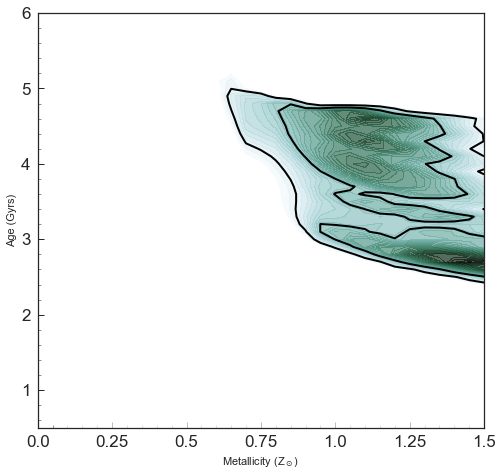

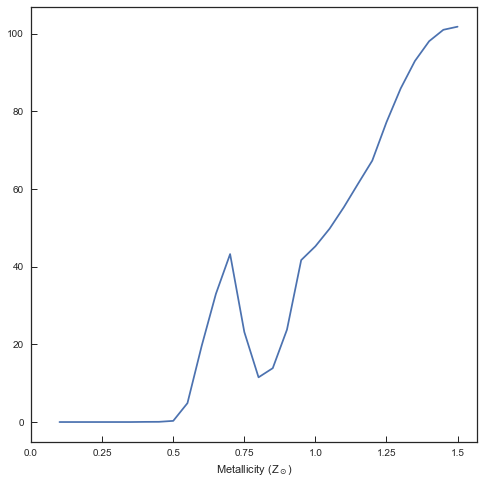

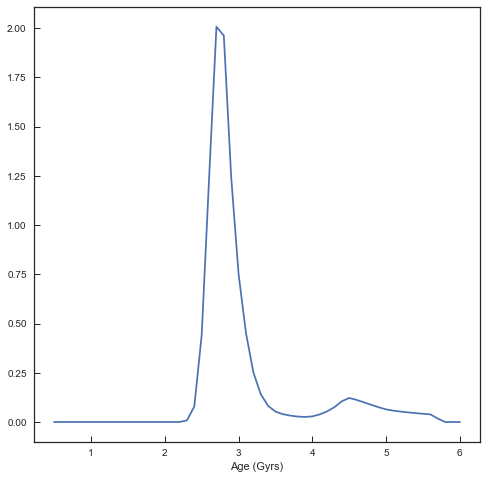

In [3]:
% matplotlib inline

Pr = np.load('../chidat/s39170_tZ_pos.npy')

onesig,twosig=Likelihood_contours(age,metal,Pr)
levels=np.array([twosig,onesig])

plt.figure(figsize=[8,8])
plt.contour(M,A,Pr,levels,colors='k',linewidths=2)
plt.contourf(M,A,Pr,40,cmap=colmap, alpha=.7)
plt.xticks([0,.005,.01,.015,.02,.025,.03],np.round(np.array([0,.005,.01,.015,.02,.025,.03])/0.02,2))
plt.tick_params(axis='both', which='major', labelsize=17)
plt.gcf().subplots_adjust(bottom=0.16)
plt.minorticks_on()
plt.xlabel('Metallicity (Z$_\odot$)')
plt.ylabel('Age (Gyrs)')
plt.legend()
plt.show()
plt.close()

Z,PZ = np.load('../chidat/39170_test_Z_pos.npy')
t,Pt = np.load('../chidat/39170_test_t_pos.npy')

plt.figure(figsize=[8,8])
plt.plot(Z,PZ)
plt.xticks([0,.005,.01,.015,.02,.025,.03],np.round(np.array([0,.005,.01,.015,.02,.025,.03])/0.02,2))
plt.xlabel('Metallicity (Z$_\odot$)')
plt.show()
plt.close()

plt.figure(figsize=[8,8])
plt.plot(t,Pt)
plt.xlabel('Age (Gyrs)')
plt.show()
plt.close()

In [47]:
for i in galDB.index:
    Pr = np.load('../chidat/%s_11_tZ_pos.npy' % galDB['gids'][i])

    onesig,twosig=Likelihood_contours(age,metal,Pr)
    levels=np.array([twosig,onesig])
    
    plt.figure(figsize=[8,8])
    plt.contour(M,A,Pr,levels,colors='k',linewidths=2)
    plt.contourf(M,A,Pr,40,cmap=colmap, alpha=.7)
    plt.xticks([0,.005,.01,.015,.02,.025,.03],np.round(np.array([0,.005,.01,.015,.02,.025,.03])/0.02,2))
    plt.tick_params(axis='both', which='major', labelsize=17)
    plt.gcf().subplots_adjust(bottom=0.16)
    plt.minorticks_on()
    plt.title(galDB['gids'][i])
    plt.xlabel('Metallicity (Z$_\odot$)')
    plt.ylabel('Age (Gyrs)')
    plt.legend()
    # plt.show()
    plt.savefig('../plots/LHS/%s_11_LH.png' % galDB['gids'][i])
    plt.close()

In [35]:
med = np.zeros(len(galDB.index))
lerr = np.zeros(len(galDB.index))
herr = np.zeros(len(galDB.index))


for i in range(len(galDB.index)):
    t, Pt = np.load('../chidat/%s_t_pos.npy' % galDB['gids'][galDB.index[i]])
    med[i],lerr[i],herr[i] = Median_w_Error(Pt,t)

In [46]:
galDB['t_+_sig'] = herr

In [48]:
galDB

,gids,ids,ra,dec,hi_res_specz,Z,Z_-_sig,Z_+_sig,t,t_-_sig,t_+_sig
43,n14713,14713,189.236333,62.214608,1.232,0.019,0.012,0.008,3.1,0.903,0.541
49,n16758,16758,189.162357,62.224840,1.014,0.021,0.002,0.002,5.5,0.470,0.125
50,n17070,17070,189.268086,62.226445,1.192,0.017,0.007,0.006,2.5,0.732,0.998
58,n19442,19442,189.123036,62.237460,1.101,0.015,0.010,0.010,2.9,1.033,0.818
61,n21156,21156,189.239409,62.247548,1.251,0.015,0.005,0.006,2.6,0.524,0.622
62,n21427,21427,189.368121,62.247344,1.514,0.020,0.009,0.007,2.8,0.779,0.533
69,n23435,23435,189.338306,62.256571,1.134,0.015,0.007,0.008,3.7,0.907,0.779
86,n32566,32566,189.161280,62.307577,1.150,0.020,0.008,0.007,2.7,1.054,0.919
96,n34694,34694,189.147840,62.323647,1.145,0.014,0.005,0.006,3.1,0.671,1.048
107,n37686,37686,189.274474,62.360820,1.258,0.016,0.003,0.003,3.6,0.598,0.548


In [49]:
# pd.to_pickle(galDB,'../data/sgal_param_DB.pkl')

In [48]:
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
hzDB = galDB.query('1.3 < hi_res_specz')

In [49]:
%matplotlib inline
Pl = np.ones(len(metal))
Pm = np.ones(len(metal))
Ph = np.ones(len(metal))

Pl11 = np.ones(len(metal))
Pm11 = np.ones(len(metal))
Ph11 = np.ones(len(metal))


for i in lzDB.index:
    Z,PZ = np.load('../chidat/%s_Z_pos.npy' % lzDB['gids'][i])
    Pl = Pl * PZ
    Z,PZ = np.load('../chidat/%s_11_Z_pos.npy' % lzDB['gids'][i])
    Pl11 = Pl11 * PZ
    
for i in mzDB.index:
    Z,PZ = np.load('../chidat/%s_Z_pos.npy' % mzDB['gids'][i])
    Pm = Pm * PZ
    Z,PZ = np.load('../chidat/%s_11_Z_pos.npy' % mzDB['gids'][i])
    Pm11 = Pm11 * PZ
    
for i in hzDB.index:
    Z,PZ = np.load('../chidat/%s_Z_pos.npy' % hzDB['gids'][i])
    Ph = Ph * PZ
    Z,PZ = np.load('../chidat/%s_11_Z_pos.npy' % hzDB['gids'][i])
    Ph11 = Ph11 * PZ

Pl /= np.trapz(Pl,metal)
Pm /= np.trapz(Pm,metal)
Ph /= np.trapz(Ph,metal)

Pl11 /= np.trapz(Pl11,metal)
Pm11 /= np.trapz(Pm11,metal)
Ph11 /= np.trapz(Ph11,metal)

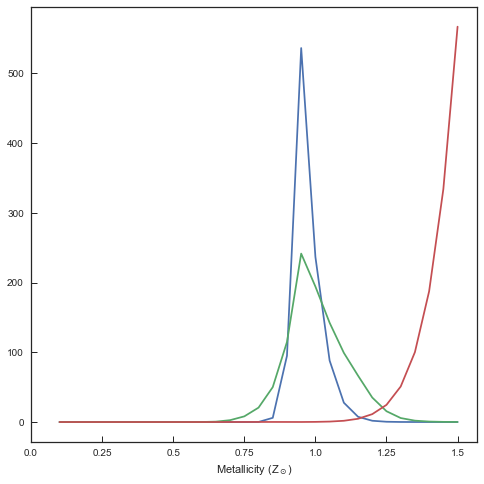

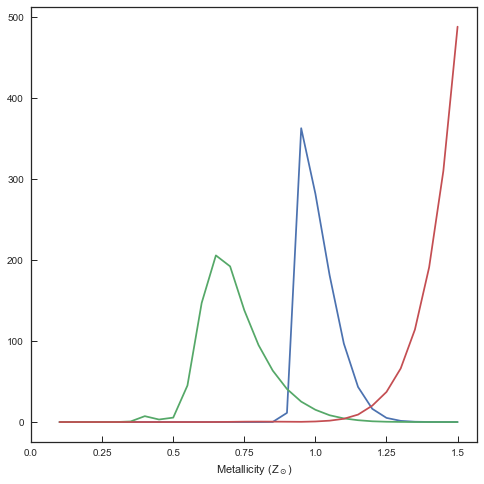

In [50]:
plt.figure(figsize=[8,8])
plt.plot(metal,Pl)
plt.plot(metal,Pm)
plt.plot(metal,Ph)
plt.xticks([0,.005,.01,.015,.02,.025,.03],np.round(np.array([0,.005,.01,.015,.02,.025,.03])/0.02,2))
plt.xlabel('Metallicity (Z$_\odot$)')
plt.show()
plt.close()

plt.figure(figsize=[8,8])
plt.plot(metal,Pl11)
plt.plot(metal,Pm11)
plt.plot(metal,Ph11)
plt.xticks([0,.005,.01,.015,.02,.025,.03],np.round(np.array([0,.005,.01,.015,.02,.025,.03])/0.02,2))
plt.xlabel('Metallicity (Z$_\odot$)')
plt.show()
plt.close()

In [51]:
%matplotlib inline
Pl = np.ones(len(age))
Pm = np.ones(len(age))
Ph = np.ones(len(age))

Pl11 = np.ones(len(age))
Pm11 = np.ones(len(age))
Ph11 = np.ones(len(age))


for i in lzDB.index:
    Z,PZ = np.load('../chidat/%s_t_pos.npy' % lzDB['gids'][i])
    Pl = Pl * PZ
    Z,PZ = np.load('../chidat/%s_11_t_pos.npy' % lzDB['gids'][i])
    Pl11 = Pl11 * PZ
    
for i in mzDB.index:
    Z,PZ = np.load('../chidat/%s_t_pos.npy' % mzDB['gids'][i])
    Pm = Pm * PZ
    Z,PZ = np.load('../chidat/%s_11_t_pos.npy' % mzDB['gids'][i])
    Pm11 = Pm11 * PZ
    
for i in hzDB.index:
    Z,PZ = np.load('../chidat/%s_t_pos.npy' % hzDB['gids'][i])
    Ph = Ph * PZ
    Z,PZ = np.load('../chidat/%s_11_t_pos.npy' % hzDB['gids'][i])
    Ph11 = Ph11 * PZ

Pl /= np.trapz(Pl,age)
Pm /= np.trapz(Pm,age)
Ph /= np.trapz(Ph,age)

Pl11 /= np.trapz(Pl11,age)
Pm11 /= np.trapz(Pm11,age)
Ph11 /= np.trapz(Ph11,age)

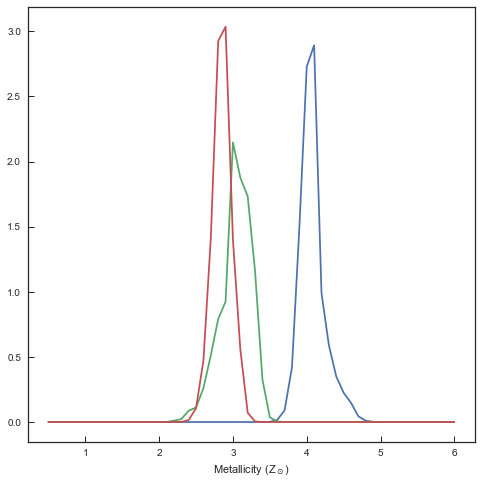

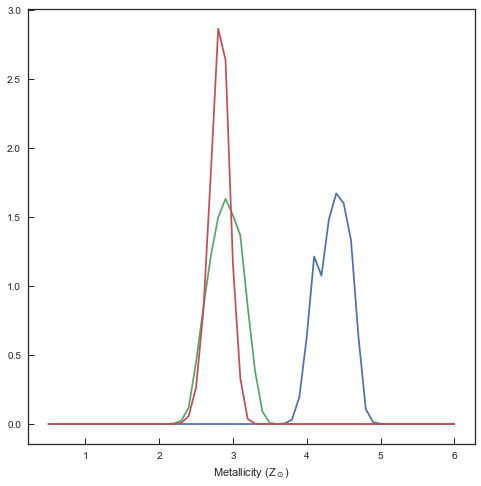

In [52]:
plt.figure(figsize=[8,8])
plt.plot(age,Pl)
plt.plot(age,Pm)
plt.plot(age,Ph)
plt.xlabel('Metallicity (Z$_\odot$)')
plt.show()
plt.close()

plt.figure(figsize=[8,8])
plt.plot(age,Pl11)
plt.plot(age,Pm11)
plt.plot(age,Ph11)
plt.xlabel('Metallicity (Z$_\odot$)')
plt.show()
plt.close()

In [3]:
spec = Gen_spec('s39170',1.022)

No TEAL-based tasks available for this package!


../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat


In [4]:
C = np.trapz(spec.gal_fl,spec.gal_wv_rf)

In [37]:
# plt.figure(figsize=[12,12])

diff = np.zeros(len(metal))
chi = np.zeros(len(metal))
for i in range(len(metal)):
    spec.Sim_spec(metal[i],4.1,8.7)
    c_dist = []
    m_dist = []
    for ii in range(len(spec.gal_fl)):
        c_dist.append(np.trapz(spec.gal_fl[:ii+1] / C ,spec.gal_wv_rf[:ii+1]))
        m_dist.append(np.trapz(spec.fl[:ii+1] / C ,spec.gal_wv_rf[:ii+1]))
    
    diff[i] = max(np.abs(np.array(c_dist) - np.array(m_dist)))
    chi[i] = sum(((spec.gal_fl - spec.fl)/spec.gal_er)**2)
    
    # plt.plot(m_dist,'--')
# plt.plot(c_dist)
# plt.show()
# plt.close()

print metal[np.argmin(diff)]
print metal[np.argmin(chi)]

0.023
0.018


In [35]:
print diff

[ 0.07119336  0.05497777  0.0467293   0.04385468  0.03948053  0.0350044
  0.03233229  0.03366263  0.03252407  0.02780319  0.02325979  0.01989255
  0.01661103  0.01340346  0.01150303  0.00964725  0.0078313   0.00675165
  0.00645786  0.00616926  0.00588539  0.00564661  0.00695271  0.00772013
  0.00847719  0.00922466  0.00996324  0.01069356  0.01141621]


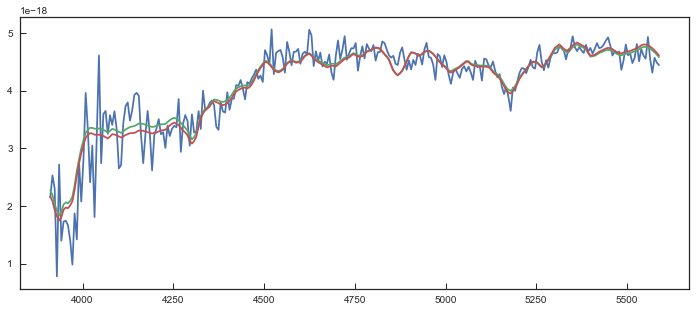

In [43]:
spec.Sim_spec(0.018,4.1,8.7)

plt.figure(figsize=[12,5])
plt.plot(spec.gal_wv_rf,spec.gal_fl)
plt.plot(spec.gal_wv_rf,spec.fl)
# plt.show()
# plt.close()

spec.Sim_spec(0.023,4.1,8.7)

# plt.figure(figsize=[12,5])
# plt.plot(spec.gal_wv_rf,spec.gal_fl)
plt.plot(spec.gal_wv_rf,spec.fl)
plt.show()
plt.close()

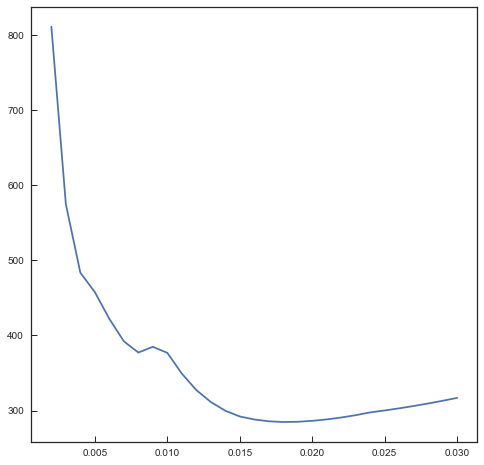

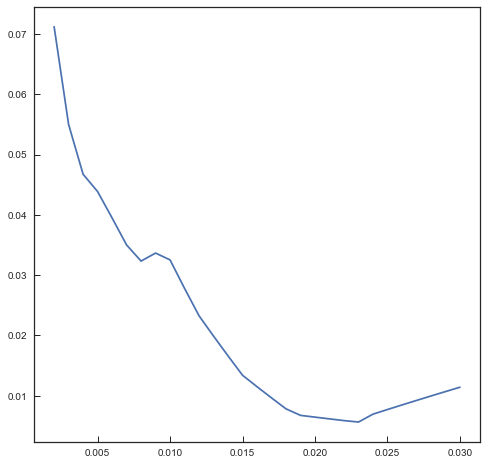

In [40]:
plt.figure(figsize=[8,8])
plt.plot(metal,chi)
plt.show()
plt.close()

plt.figure(figsize=[8,8])
plt.plot(metal,diff)
plt.show()
plt.close()

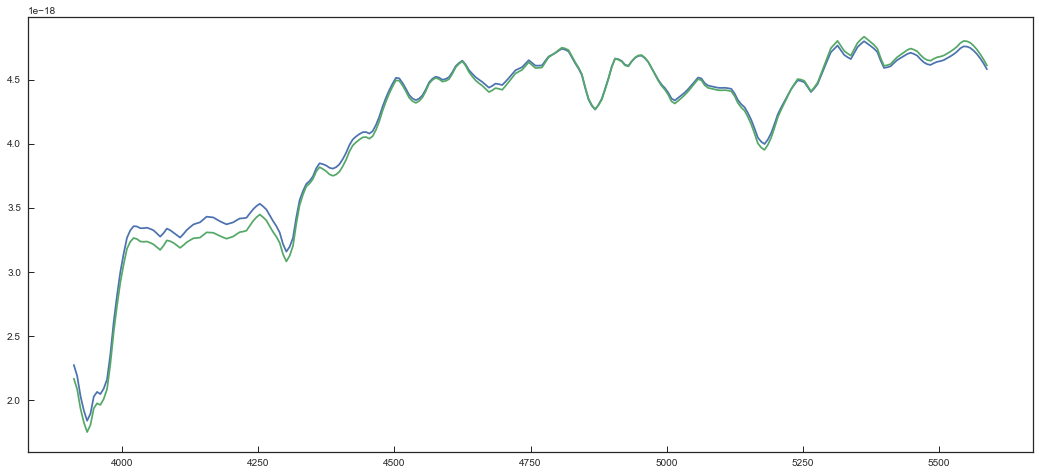

In [42]:
spec.Sim_spec(0.018,4.1,8.7)

plt.figure(figsize=[18,8])
plt.plot(spec.gal_wv_rf,spec.fl)

spec.Sim_spec(0.023,4.1,8.7)

plt.plot(spec.gal_wv_rf,spec.fl)
plt.show()
plt.close()

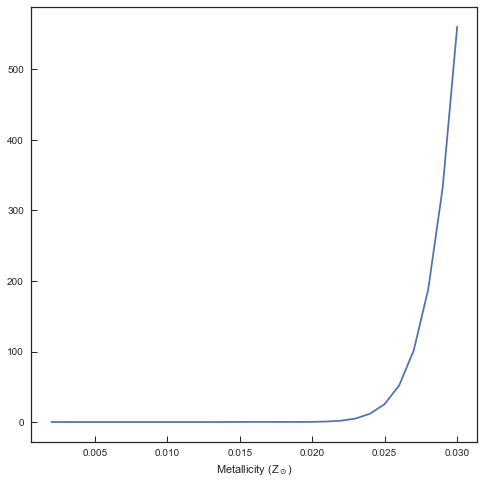

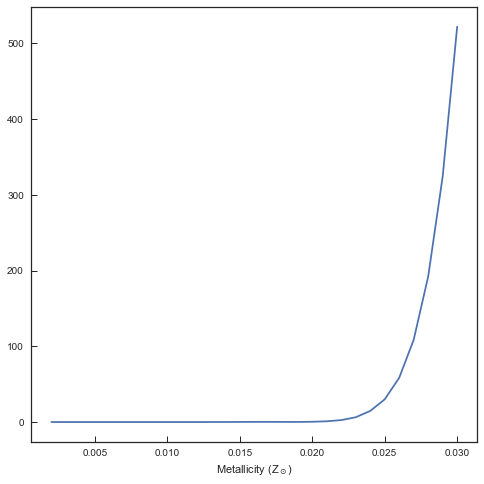

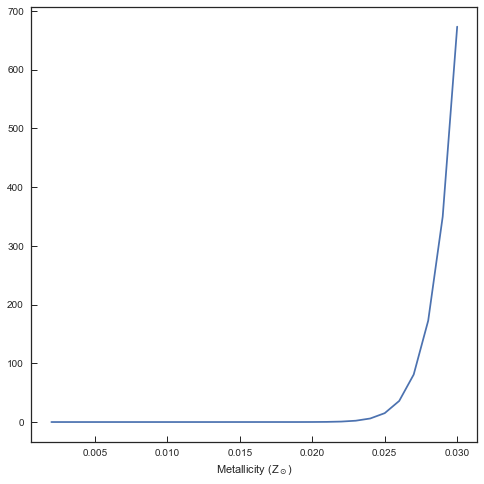

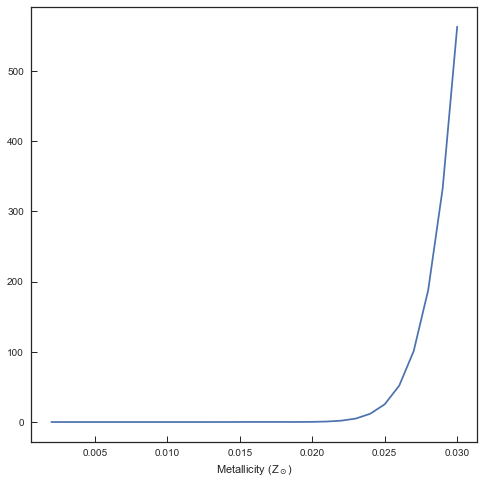

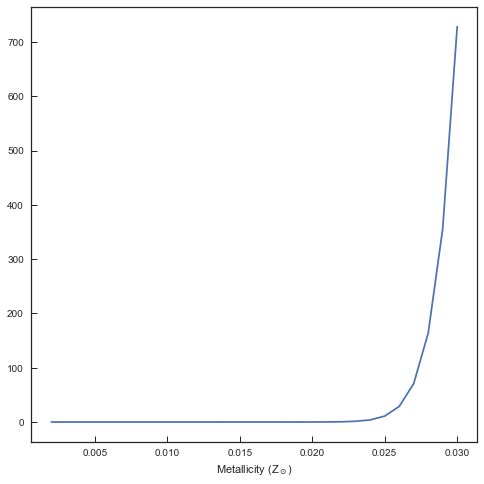

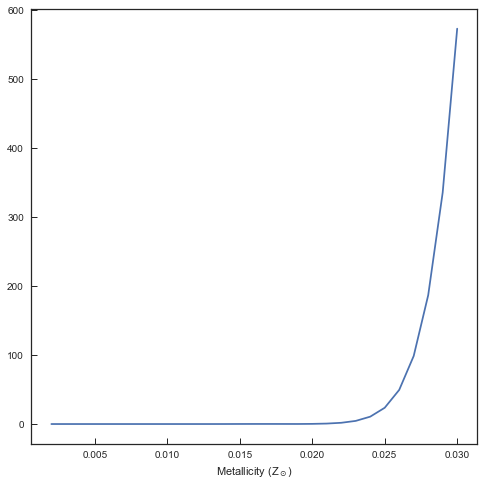

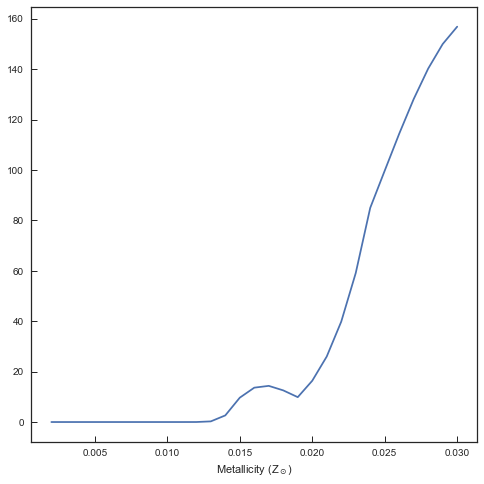

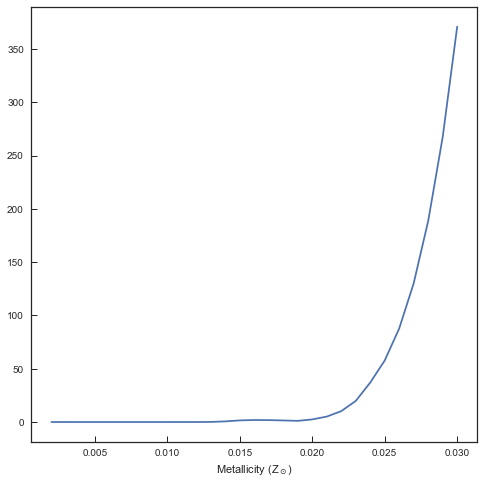

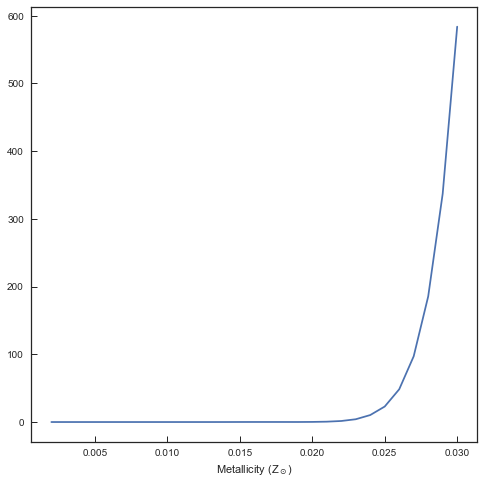

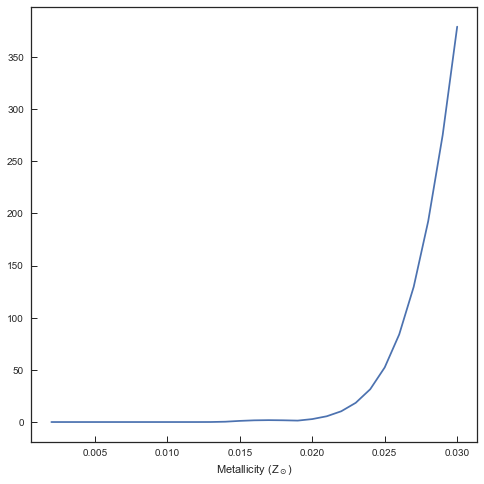

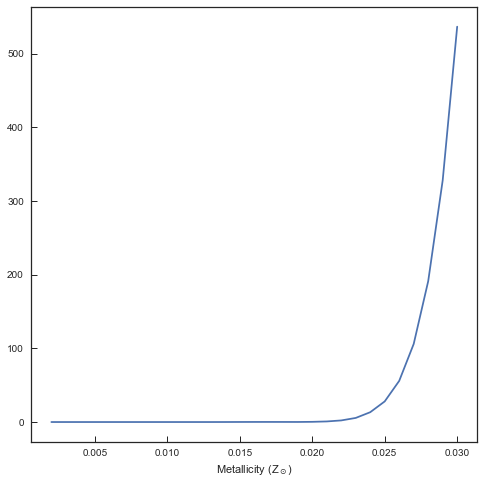

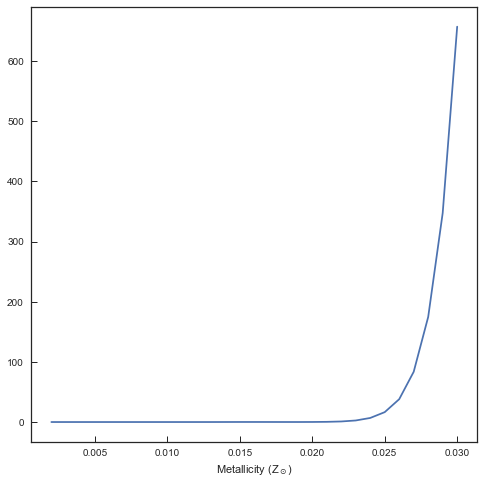

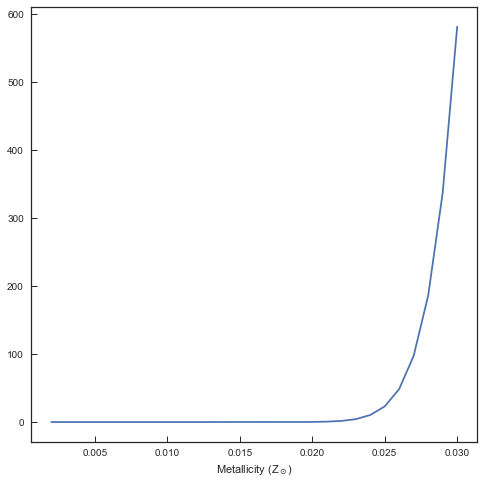

In [55]:
%matplotlib inline
Ph = np.ones(len(metal))

for i in range(len(hzDB.index)):
    Ph = np.ones(len(metal))
    for ii in hzDB.index:
        if ii != hzDB.index[i]:
            Z,PZ = np.load('../chidat/%s_Z_pos.npy' % hzDB['gids'][ii])
            Ph = Ph * PZ
    Ph /= np.trapz(Ph,metal)

    plt.figure(figsize=[8,8])
    plt.plot(metal,Ph)
    plt.xlabel('Metallicity (Z$_\odot$)')
    plt.show()
    plt.close()

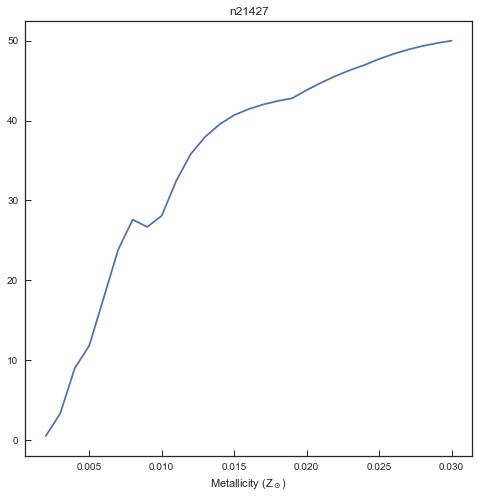

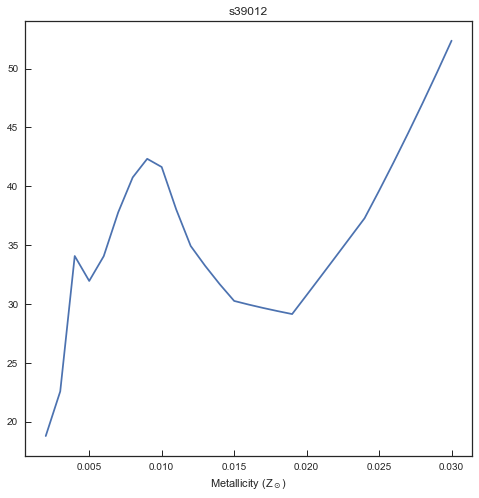

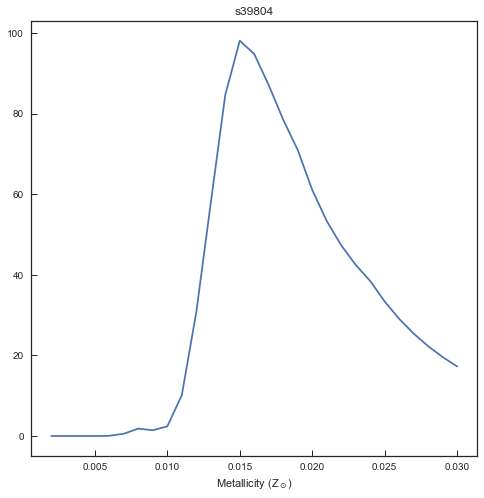

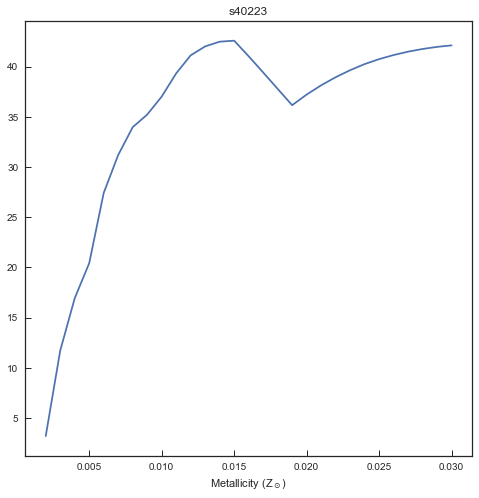

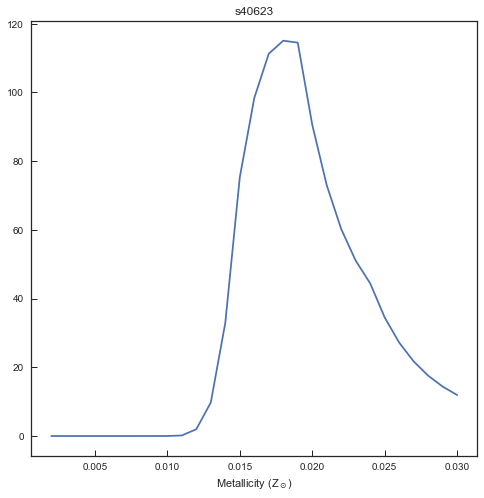

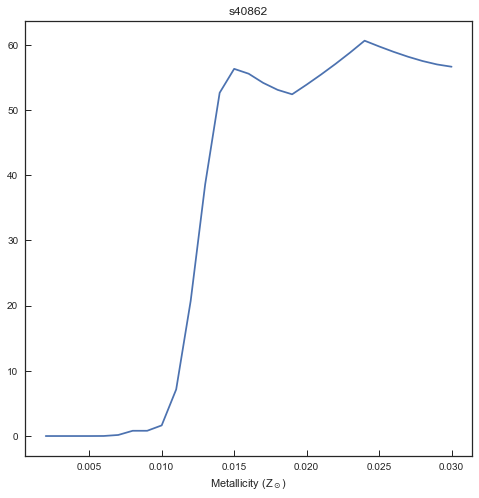

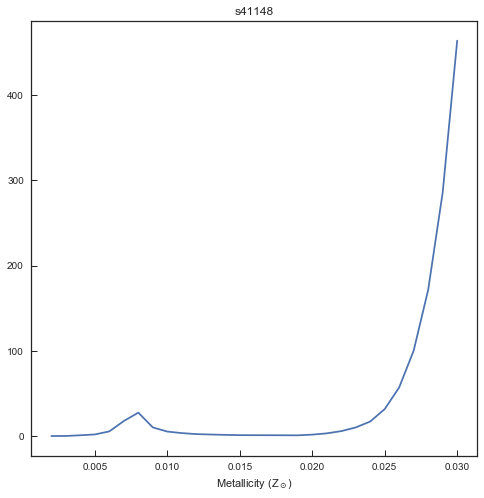

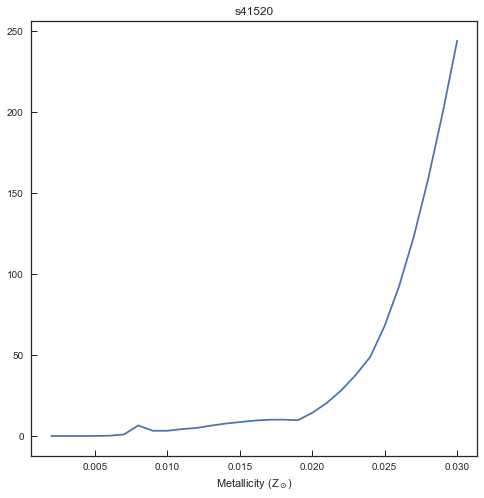

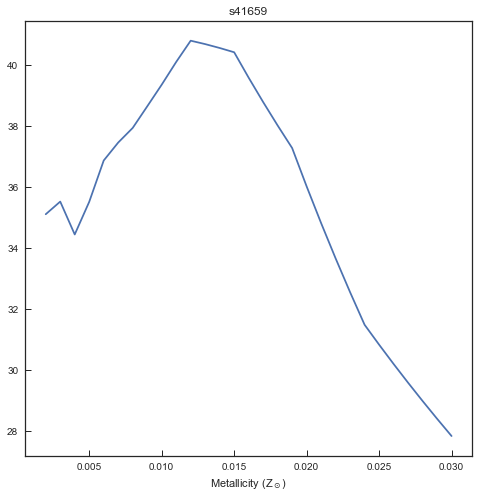

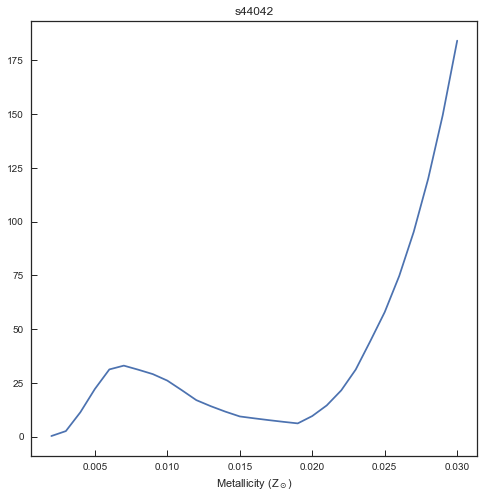

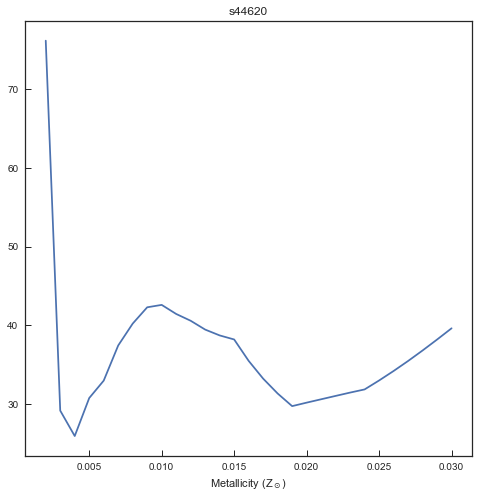

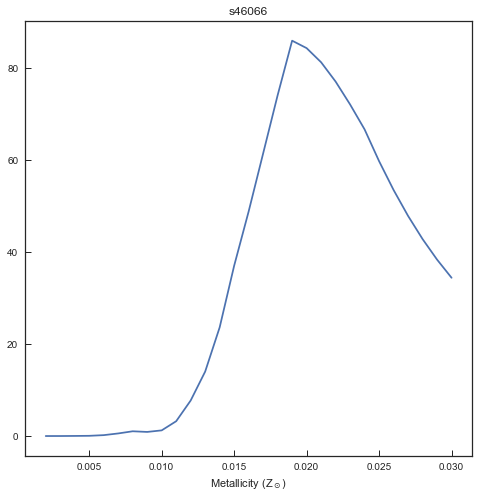

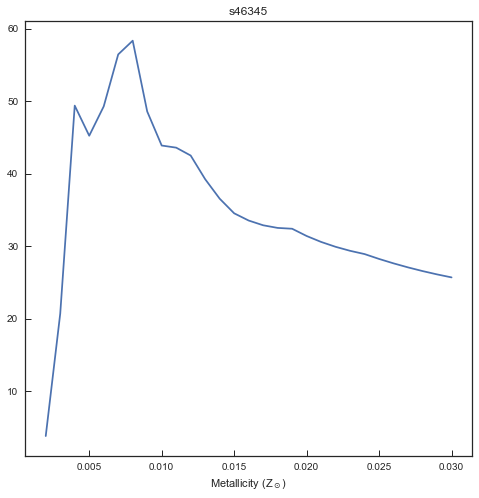

In [57]:
%matplotlib inline
for ii in hzDB.index:
    Z,PZ = np.load('../chidat/%s_Z_pos.npy' % hzDB['gids'][ii])

    plt.figure(figsize=[8,8])
    plt.plot(metal,PZ)
    plt.xlabel('Metallicity (Z$_\odot$)')
    plt.title(hzDB['gids'][ii])
    plt.show()
    plt.close()